<a target="_blank" href="https://colab.research.google.com/github/fintech-dl-hse/course/blob/main/seminars/05_cv/05_seminar_cv.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Computer Vision


In [ ]:
!pip install -q efficientnet_pytorch ultralytics pytorch-lightning kaggle

## Работа над ошибками

#### Кейс: куда уходит память при первом переносе на GPU?

Если перенести на CUDA один скаляр — `torch.tensor([1.0]).to('cuda')` — в мониторе видеопамяти (например, `nvidia-smi`) видно, что аллоцируется порядка **100 MB**. Сам тензор занимает считаные байты. Куда расходуется остальная память?

<details>

<summary><strong>Ответ</strong></summary>

Основная часть памяти уходит на **контекст CUDA** (CUDA context), который создаётся при первом обращении к GPU из процесса:</br>
</br>
- загрузка и инициализация драйвера и CUDA runtime;</br>
- кэши ядер (JIT-компиляция при первом вызове операций);</br>
- внутренние структуры менеджера памяти (allocator), пулы и страницы — PyTorch/CUDA резервируют блоки памяти для последующих аллокаций, чтобы уменьшить число обращений к драйверу;</br>
- служебные буферы и структуры для работы с устройством.</br>
</br>
Сам тензор занимает минимум (например, 4 байта для одного float). Оставшиеся ~100 MB — это «стартовый» контекст GPU в этом процессе; дальше аллокации идут уже поверх него и не добавляют такой разовой нагрузки.

</details>

In [ ]:
# Пример: один скаляр на GPU — малый тензор, но видна аллокация контекста
import torch
torch.cuda.reset_peak_memory_stats()
x = torch.tensor([1.0]).to("cuda")
allocated_mb = torch.cuda.memory_allocated() / (1024**2)
print(f"Аллоцировано после .to('cuda'): {allocated_mb:.1f} MB")
print(f"Размер тензора в байтах: {x.element_size() * x.numel()}")

#### ❓ **Вопрос**: Почему в наследниках `nn.Module` обязательно вызывать `super().__init__()`?

<details>

<summary><strong>Ответ</strong></summary>

В `nn.Module.__init__()` создаётся внутреннее состояние модуля: словари `_parameters`, `_modules`, `_buffers`, флаг `training`, привязка к устройству и dtype. Без вызова `super().__init__()` этот код не выполняется — экземпляр не считается полноценным модулем. Тогда не работают корректно `.parameters()`, `.to(device)`, `.train()` / `.eval()`, загрузка state_dict и обход вложенных модулей.</br>

</details>

## Recap

#### ❓ **Вопрос**: Что такое `transfer learning`, `fine-tuning`?

<details>

<summary><strong>Ответ</strong></summary>

Способ переиспользовать параметры сети, обученной на другой задаче.</br>

</details>


#### ❓ **Вопрос**: Почему делают `transfer learning`, `fine-tuning`? Почему с нуля не учат?

<details>

<summary><strong>Ответ</strong></summary>

Сети быстрее дообучить, чем обучить с нуля. Иногда с нуля сложно обучить, потому что датасет маленький. Если датасет большой, то все равно хорошо --- можно считать, что будет больше данных, меньше вероятность переобучиться.</br>

</details>


#### ❓ **Вопрос**: В чем разница?

<details>

<summary><strong>Ответ</strong></summary>

В общем-то, `fine-tuning` --- это подмножество `transfer learning`.</br>

</details>


#### ❓ **Вопрос**: Как заморозить веса сети? Какие стратегии разморозки можете предложить?

<details>

<summary><strong>Ответ</strong></summary>

```python
# замораживаем веса для backbone'а сети
for p in resnet.parameters():
    p.requires_grad = False

# размораживаем наш классификатор
for p in resnet.fc.parameters():
    p.requires_grad = True
```

https://cs231n.github.io/transfer-learning/</br>

</details>

#### ❓ **Вопрос**: В каком месте нужно располагать слой `BatchNorm` внутри Residual блоков?

```python
nn.Conv2d(...) -> nn.BatchNorm2d() -> nn.ReLU()
```

```python
nn.BatchNorm2d() -> nn.ReLU() -> nn.Conv2d(...)
```

```python
nn.Conv2d(...) -> nn.ReLU() -> nn.BatchNorm2d()
```

<details>

<summary><strong>Ответ</strong></summary>

1. ✅ Первый вариант — это база, используем по умолчанию</br>
2. 👌 Второй допустим для глубоких слоев</br>
3. ❌ BatchNorm пытается нормализовать уже искаженное распределение, теряется много информации, статистики BN могут быть нестабильными</br>

</details>

#### ❓ **Вопрос**: Какое рецептивное поле у одной ячейки выходного тензора сверточной сети, состоящей из двух подряд идущих сверток 3×3 (`stride=1`)?

Другими словами: какое количество пикселей исходного изображения «вложили» свои значения в один пиксель итогового фильтра?

<details>

<summary><strong>Ответ</strong></summary>

Ответ: 5×5=25. Рецептивное поле одного пикселя первого фильтра 3×3. Квадратик 3×3 этого фильтра соответствует одному «пикселю» второго фильтра и квадратику 5×5 исходного изображения.</br>

</details>

#### ❓ **Вопрос**: Зачем мы хотим увеличить рецептивное поле на более глубоких слоях?

<details>

<summary><strong>Ответ</strong></summary>

В задаче классификации последним идёт Linear по последней фича-мапе. Linear не учитывает расположение пикселей и их «соседство». Значения последнего фильтра могут нести эту информацию; чем больше рецептивное поле, тем больше информации можно сохранить в последнем фильтре.</br>

</details>

## Задачи компьютерного зрения

<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/05_cv/static/cv_tasks.png" width=600 />

[**Источник**](https://cs231n.stanford.edu/slides/2024/lecture_9.pdf)

## Классификация

### [ResNet](https://arxiv.org/abs/1512.03385) (2015)

**Ключевая фишка:** skip-connection (residual block)

**Цель:** Обучить глубокую сеть. Резидуалы помогают градиентам протекать на глубокие слои.

<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/05_cv/static/resnet.png" width=600 />

**Легенда**:
Закрашенные квадраты — это активации. Высота квадрата — пространственные размерности. Ширина — количество каналов.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
import torch

# 2015
resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet

In [ ]:
resnet.fc = nn.Linear(512, 10) # Randomly initialized! Must be trained!

In [ ]:
class ExampleResidualModel(nn.Module):
    """Минимальный пример residual блока: выход = activation(conv(x)) + x."""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        conved = self.model(x)
        return self.activation(conved) + x

### [EfficientNet](https://arxiv.org/abs/1905.11946) (2019)

**Цель:** модель общего назначения с хорошим масштабированием.

**NAS** (Neural Architecture Search) — автоматический поиск оптимальной архитектуры сети. Вместо того чтобы проектировать сеть вручную, алгоритм перебирает варианты блоков, связей и гиперпараметров, оптимизируя качество на валидации. Это дорого по вычислениям, но результат — архитектура, подобранная под конкретную задачу.

**Compound Scaling** — совместное масштабирование глубины, ширины (каналов) и разрешения входа; оптимизация по FLOPS и качеству. В блоках: активация **Swish** $f(x)=x\sigma(x)$ и **depthwise-свертки** (ниже).

<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/05_cv/static/efficient_net_metrics.png" width=400 />

*(График Swish и детали — см. [Wikipedia](https://en.wikipedia.org/wiki/Swish_function).)*




#### [Depthwise Convolution](https://paperswithcode.com/method/depthwise-convolution)



**Depthwise convolution:** по каждому каналу входа применяется свой фильтр, каналы не смешиваются. Параметров меньше, чем у обычной свертки (см. ячейки с `groups=` ниже).


Го в гифку снова https://cs231n.github.io/convolutional-networks/



<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/05_cv/static/depthwise_conv_doc.png" width=400 />

In [2]:
from torch import nn

# depthwise: groups = in_channels = out_channels → один фильтр на канал
nn.Conv2d(10, 10, kernel_size=3, groups=10)  # 10 × (1×1×3×3 + 1) = 100 параметров
sum(p.numel() for p in nn.Conv2d(10, 10, kernel_size=3, groups=10).parameters())


100

In [3]:
# для сравнения: обычная свертка 10→10, 3×3 — 910 параметров
sum(p.numel() for p in nn.Conv2d(10, 10, kernel_size=3, groups=1).parameters())

910

In [ ]:
from efficientnet_pytorch import EfficientNet
# 20 MB
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
efficientnet

### [ConvNeXt](https://arxiv.org/abs/2201.03545) (2022)

**Цель:** модель общего назначения с хорошим масштабированием. **Идея:** перенести архитектурные решения из трансформеров (ViT) в чисто сверточную сеть — без блоков внимания.

Ниже перечислены ключевые фишки; код блока и стохастичная глубина — в следующих ячейках.


#### Фишки ConvNeXt

- **Stem (patchify):** первый слой — свертка 4×4 со stride 4 (как разбиение на патчи в ViT), сразу уменьшает пространственное разрешение.

- **LayerNorm вместо BatchNorm:** нормализация по каналам внутри каждого примера; как в трансформерах, стабильнее при малом batch.

- **Большое ядро 7×7:** в каждом блоке — depthwise-свертка 7×7 (а не 3×3), больше рецептивное поле, по духу ближе к «окну» в ViT.

- **Inverted bottleneck (MLP-подобный блок):** после свертки идут два линейных слоя: сначала расширение в 4× каналов, затем сжатие обратно (как FFN в трансформере). В коде — `Linear(dim → 4*dim)` → GELU → `Linear(4*dim → dim)`.

- **GELU:** активация $x\Phi(x)$ вместо ReLU; как в BERT/ViT.

- **Layer scale:** обучаемый скаляр (или вектор по каналам), на который умножают выход блока перед residual: стабилизирует обучение глубоких сетей.

- **Stochastic Depth (стохастичная глубина):** с вероятностью $p$ выход блока обнуляется (ветка «пропускается»), residual остаётся. Вероятность $p$ растёт с глубиной слоя. Регуляризация и ускорение обучения.

In [ ]:
import torchvision
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 400MB
net = torchvision.models.convnext_base(weights='ConvNeXt_Base_Weights.DEFAULT')
net.to(device)

#### Stochastic Depth

**Stochastic Depth** — приём регуляризации для глубоких residual-сетей: во время обучения с вероятностью $p$ выход блока обнуляется и остаётся только residual-соединение. Вероятность $p$ обычно растёт с глубиной слоя (ближе к выходу — чаще пропускаем). Это ускоряет обучение и действует как регуляризация (похоже на dropout, но на уровне целых блоков).

Реализация в torchvision: [`torchvision.ops.StochasticDepth`](https://pytorch.org/vision/main/_modules/torchvision/ops/stochastic_depth.html#StochasticDepth)

Оригинальная статья: [Deep Networks with Stochastic Depth (2016)](https://arxiv.org/abs/1603.09382)

<image src="./static/stochastic_depth.png" width=600>

## Семантическая сегментация

<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/05_cv/static/sem_seg.png" width=400 />

[Источник](https://thegradient.pub/semantic-segmentation/)

In [ ]:
image = torch.randn(1, 3, 32, 32)  # [ bs, channels, w, h ]
target = torch.randint(0, 5, (1, 32, 32))  # [ bs, w, h ] class indices

model = nn.Sequential(
    nn.Conv2d(3, 256, kernel_size=3, padding=1),
    nn.Conv2d(256, 5, kernel_size=3, padding=1),
)

predictions = model(image)  # [ bs, n_classes, H, W ]


### [Unet](https://arxiv.org/abs/1505.04597) (2015)

<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/05_cv/static/unet.png" width=600 />

#### ❓ **Вопрос**: Что обозначено синими прямоугольниками на картинке?

<details>

<summary><strong>Ответ</strong></summary>

Синие прямоугольники — это активации (фича-мапы) на разных слоях U-Net при проходе вперёд: на каждом уровне энкодера и декодера показаны промежуточные тензоры по форме $[C, H, W]$. По ним видно, как меняются пространственные размеры и количество каналов вдоль сети.</br>

</details>

### Давайте сравним Unet и ResNet



In [8]:
# https://github.com/milesial/Pytorch-UNet/

"""Parts of the U-Net model."""

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """Два последовательных блока (Conv2d → BN → ReLU)."""

    def __init__(self, in_channels: int, out_channels: int, mid_channels: int | None = None) -> None:
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv(x)


class Down(nn.Module):
    """Понижение разрешения: MaxPool → DoubleConv."""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Повышение разрешения: Upsample → конкатенация со skip-connection → DoubleConv."""

    def __init__(self, decoder_channels: int, skip_channels: int, out_channels: int) -> None:
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # После cat([skip, upsampled]) получаем skip_channels + decoder_channels
        concat_channels = skip_channels + decoder_channels
        self.conv = DoubleConv(concat_channels, out_channels, concat_channels // 2)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """Финальная свертка 1×1 для получения нужного числа классов."""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class UNet(nn.Module):
    """U-Net: encoder (down) → bottleneck → decoder (up) со skip-connections."""

    def __init__(self, n_channels: int, n_classes: int) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512, 512)
        self.up2 = Up(512, 256, 256)
        self.up3 = Up(256, 128, 128)
        self.up4 = Up(128, 64, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
# Сравнение UNet и ResNet: forward pass + число параметров
from torchvision.models import resnet18, ResNet18_Weights

unet = UNet(n_channels=3, n_classes=5)
resnet_cmp = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet_cmp.fc = nn.Linear(512, 5)

dummy = torch.randn(1, 3, 128, 128)

# UNet: вход и выход — одинаковое пространственное разрешение
unet_out = unet(dummy)
print(f"UNet:   вход {tuple(dummy.shape)} → выход {tuple(unet_out.shape)}")

# ResNet: выход — один вектор на изображение
resnet_out = resnet_cmp(dummy)
print(f"ResNet: вход {tuple(dummy.shape)} → выход {tuple(resnet_out.shape)}")

def count_params(model: nn.Module) -> int:
    """Подсчёт обучаемых параметров модели."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nUNet   параметров: {count_params(unet):,}")
print(f"ResNet параметров: {count_params(resnet_cmp):,}")
print(f"\nResNet — классификатор: один вектор [bs, n_classes] на картинку")
print(f"UNet   — сегментатор: карта [bs, n_classes, H, W] — предсказание для каждого пикселя")

UNet:   вход (1, 3, 128, 128) → выход (1, 5, 128, 128)
ResNet: вход (1, 3, 128, 128) → выход (1, 5)

UNet   параметров: 37,652,933
ResNet параметров: 11,179,077

ResNet — классификатор: один вектор [bs, n_classes] на картинку
UNet   — сегментатор: карта [bs, n_classes, H, W] — предсказание для каждого пикселя


#### ❓ **Вопрос**: С каким лоссом должен обучаться Unet?

<details>

<summary><strong>Ответ</strong></summary>

Для семантической сегментации U-Net обычно обучают с пиксель-уровневым лоссом: кросс-энтропия (или взвешенная CE при дисбалансе классов), либо Dice / Focal loss по маске. Часто комбинируют несколько лоссов (например, CE + Dice). Важно, что целевая переменная — маска того же пространственного разрешения, что и выход сети.</br>

</details>

#### ❓ **Вопрос**: Можно ли применять unet для задачи классификации класса картинки?

<details>

<summary><strong>Ответ</strong></summary>

Технически можно: сделать глобальный пулинг (например, по карте признаков на выходе декодера) и один линейный слой в число классов. Но U-Net заточен под плотный вывод «на каждый пиксель»; для чистой классификации одной картинки обычно берут классификаторы (ResNet, EfficientNet и т.д.), без лишних затрат на декодер и высокое разрешение.</br>

</details>

### Лоссы в сегментации

- **Cross-Entropy (pixel-wise):** по каждому пикселю предсказание класса. Формула:

$$ \mathcal{L}_{CE} = -\frac{1}{HW}\sum_{h,w} \sum_{c=1}^{C} y_{h,w,c} \log \hat{p}_{h,w,c} $$

где $y_{h,w,c}$ — one-hot по классам для пикселя $(h,w)$, $\hat{p}_{h,w,c}$ — предсказанная вероятность класса $c$.

**Взвешивание в CE:** при несбалансированных классах (например, мало пикселей объекта) задают веса $w_c$ для каждого класса: $\mathcal{L}_{CE}^{w} = -\frac{1}{HW}\sum_{h,w} \sum_c w_c \, y_{h,w,c} \log \hat{p}_{h,w,c}$. Часто $w_c \propto 1/\text{частота класса } c$ или корень из него.

- **Dice loss:** хорошо работает при несбалансированных классах. Коэффициент Dice: $\text{Dice} = \frac{2|X \cap Y|}{|X|+|Y|}$, лосс $\mathcal{L}_{Dice} = 1 - \text{Dice}$ (для мягких предсказаний — по каналам классов).

- **Focal loss:** $FL(p_t) = -\alpha_t (1-p_t)^\gamma \log(p_t)$ — уменьшает вес «лёгких» примеров, фокус на сложных пикселях.

- **Комбинации:** например, $\mathcal{L} = \mathcal{L}_{CE} + \mathcal{L}_{Dice}$ для стабильного обучения.

- **Instance segmentation** (Mask R-CNN): к лоссам детекции добавляют лосс на маску — BCE или Dice по пикселям маски.


## Детекция объектов

### [YOLOv5](https://github.com/ultralytics/yolov5) (2020)

PS Самая свежая версия YOLO — 11. Но мы не сможем её подробно разобрать, т.к. там используется блок внимания, который мы пока не проходили.

- **Backbone** — CSPDarknet (**C**ross **S**tage **P**artial Network) — модифицированная сверточная сеть для извлечения признаков. «Cross Stage Partial» означает, что на каждом этапе часть каналов обходит тяжёлые свертки и конкатенируется с результатом, что уменьшает вычисления и улучшает поток градиентов.
- **Neck** — PANet (Path Aggregation Network) — модуль, который объединяет признаки с разных масштабов (мелкие и крупные объекты). Работает как FPN (Feature Pyramid Network), но с дополнительным bottom-up путём для лучшей передачи информации между уровнями.
- **Head** — BBox Prediction, Classes Prediction
- **Postprocessing** — Non-Maximum Suppression (NMS)

#### Non-Maximum Suppression (NMS)

Детектор выдаёт тысячи предсказаний bounding box'ов, многие из которых перекрываются для одного и того же объекта. NMS фильтрует дубликаты:

1. Сортируем все bbox'ы по confidence (уверенности)
2. Берём bbox с наивысшей confidence — он остаётся
3. Удаляем все bbox'ы, которые сильно перекрываются с ним (IoU > порог, обычно 0.5)
4. Повторяем для оставшихся bbox'ов

---

[Статья Datasecrets - История YOLO – самой известной архитектуры компьютерного зрения](https://datasecrets.ru/articles/20)

<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/05_cv/static/yolov5.png" width=400 />

[Источник](https://www.researchgate.net/figure/The-network-architecture-of-YOLOv5-1-Backbone-CSPDarknet-for-feature-extraction-2_fig1_358553872)

In [13]:
!curl http://djl.ai/examples/src/test/resources/dog_bike_car.jpg --output dog_bike_car.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  159k  100  159k    0     0   764k      0 --:--:-- --:--:-- --:--:--  765k


Using cache found in /Users/d.tarasov/.cache/torch/hub/ultralytics_yolov5_master


requirements: Ultralytics requirement ['urllib3>=2.6.0 ; python_version > "3.8"'] not found, attempting AutoUpdate...
WARNING ⚠️ Retry 1/2 failed: Command 'pip install --no-cache-dir "urllib3>=2.6.0 ; python_version > "3.8"" ' returned non-zero exit status 2.
WARNING ⚠️ Retry 2/2 failed: Command 'pip install --no-cache-dir "urllib3>=2.6.0 ; python_version > "3.8"" ' returned non-zero exit status 2.
WARNING ⚠️ requirements: ❌ Command 'pip install --no-cache-dir "urllib3>=2.6.0 ; python_version > "3.8"" ' returned non-zero exit status 2.
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/d.tarasov/miniconda3/envs/audio/lib/python3.10/site-packages/pip/_vendor/packaging/markers.py", line 266, in __init__
    self._markers = _normalize_extra_values(_parse_marker(marker))
  File "/Users/d.tarasov/miniconda3/envs/audio/lib/python3.10/site-packages/pip/_vendor/packaging/_parser.py", line 253, in parse_marker
    return _parse_full_marker(Tokenizer(source, rules=DEFAULT_RULES)

YOLOv5 🚀 2026-2-16 Python-3.10.15 torch-2.10.0 CPU

100%|██████████| 14.1M/14.1M [00:03<00:00, 4.59MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/Users/d.tarasov/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


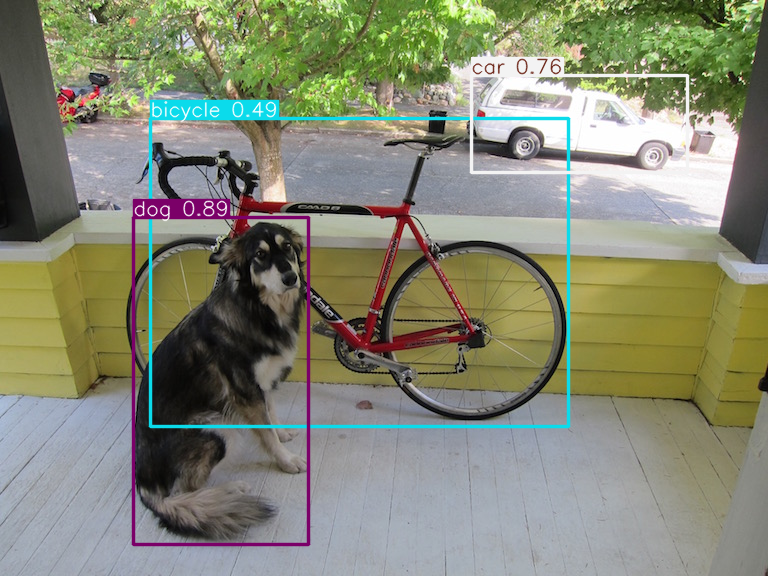

In [15]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка предобученной модели (YOLOv5s - самая лёгкая версия)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model config
# https://github.com/ultralytics/yolov5/blob/master/models/yolov5s.yaml

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.to(device)

# Загрузка изображения
image_path = 'dog_bike_car.jpg'
image = Image.open(image_path)

# Отображаем исходное изображение
plt.imshow(image)
plt.axis('off')
plt.show()

# Запуск предсказания
results = model(image)

# Отображение результатов
results.show()


In [16]:
results

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 576x768 1 bicycle, 1 car, 1 dog
Speed: 3.7ms pre-process, 65.1ms inference, 8.8ms NMS per image at shape (1, 3, 480, 640)

In [17]:
detection_model = model.model.model

type(detection_model)

models.yolo.DetectionModel

In [ ]:
# Checkout model config
# https://github.com/ultralytics/yolov5/blob/master/models/yolov5s.yaml

In [18]:
detection_model.save

[4, 6, 10, 14, 17, 20, 23]

In [19]:
for i, m in enumerate(detection_model.model):
    print(i, "\t", m.f)

0 	 -1
1 	 -1
2 	 -1
3 	 -1
4 	 -1
5 	 -1
6 	 -1
7 	 -1
8 	 -1
9 	 -1
10 	 -1
11 	 -1
12 	 [-1, 6]
13 	 -1
14 	 -1
15 	 -1
16 	 [-1, 4]
17 	 -1
18 	 -1
19 	 [-1, 14]
20 	 -1
21 	 -1
22 	 [-1, 10]
23 	 -1
24 	 [17, 20, 23]


In [20]:
from torchvision.transforms import ToTensor

image_t = ToTensor()(image)
image_t = image_t.unsqueeze(0).to(device)
image_t.shape

torch.Size([1, 3, 576, 768])

In [21]:
# from forward once in Base Model
# https://github.com/ultralytics/yolov5/blob/5cdad8922c83b0ed49a0173cd1a8b0739acbb336/models/yolo.py#L161

def forward_once(detection_model, x):
    y, dt = [], []  # outputs
    for m in detection_model.model:
        if m.f != -1:  # if not from previous layer
            x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # from earlier layers

        x = m(x)  # run
        y.append(x if m.i in detection_model.save else None)  # save output

    return x

forward_result = forward_once(detection_model, image_t)
forward_result = forward_result[0]

In [22]:
forward_result.shape

torch.Size([1, 27216, 85])

In [23]:
# forward_result ~ [ bs, bbox_num, bbox_params + object confidence + class_probability ]

# bbox_params + object confidence = 5 params
# class_probability = 80 params

# bbox_params = [ cx, cy, w, h ]

most_confident_bboxes = forward_result[forward_result[..., 4] > 0.75]
most_confident_bboxes.shape

torch.Size([11, 85])

In [ ]:
# Вот почему нужен NMS
most_confident_bboxes[:, :4].round()

tensor([[581., 124., 215., 101.],
        [581., 124., 214., 101.],
        [578., 123., 216.,  99.],
        [579., 123., 211.,  98.],
        [579., 124., 212.,  99.],
        [578., 123., 215.,  99.],
        [579., 123., 211.,  98.],
        [579., 124., 212.,  99.],
        [578., 123., 216.,  99.],
        [579., 123., 211.,  98.],
        [579., 123., 212.,  99.]])

### Лоссы в детекции объектов

- **Классификация:** Cross-Entropy или Binary Cross-Entropy по классам. Для BCE по классам (one-stage): $\mathcal{L}_{class} = \sum_i \left[ -y_i \log \hat{p}_i - (1-y_i)\log(1-\hat{p}_i) \right]$.

- **Регрессия bbox:** L1: $|x - \hat{x}|$; Smooth L1 (Huber) — меньше чувствительности к выбросам; IoU-подобные (GIoU, DIoU, CIoU): $\mathcal{L}_{bbox} = 1 - \text{IoU}$ (или $1 - \text{GIoU}$ / DIoU / CIoU), учитывают перекрытие и форму бокса.

- **Objectness:** Binary Cross-Entropy — есть ли объект в ячейке/анкоре: $\mathcal{L}_{obj}$.

**Итоговый лосс** (YOLO и другие one-stage детекторы):

$$ \mathcal{L} = \lambda_{coord} \, \mathcal{L}_{bbox} + \mathcal{L}_{obj} + \lambda_{class} \, \mathcal{L}_{class} $$

где $\lambda_{coord}$, $\lambda_{class}$ — веса (например, $\lambda_{coord}=5$, $\lambda_{class}=1$); слагаемые считают по всем ячейкам/анкорам с учётом масок по наличию объекта, как в конкретной реализации.


#### ❓ **Вопрос**: Почему для классификации используется Binary Cross-Entropy, а не CrossEntropy?



---

## Аугментации

Аугментации — преобразования изображений, которые применяются **случайно** во время обучения. Зачем:

- **Увеличение разнообразия данных** — модель видит больше вариаций одного и того же объекта
- **Регуляризация** — уменьшает переобучение, т.к. модель не запоминает конкретные пиксели
- **Инвариантность** — модель учится быть устойчивой к сдвигам, поворотам, изменениям яркости

Основные типы аугментаций:

| Аугментация | Что делает | Когда полезна |
|---|---|---|
| `RandomHorizontalFlip` | Зеркальное отражение по горизонтали | Почти всегда (кроме текста, цифр) |
| `RandomResizedCrop` | Случайный кроп + масштабирование | Масштабная инвариантность |
| `ColorJitter` | Случайные изменения яркости, контраста, насыщенности | Инвариантность к освещению |
| `RandomRotation` | Случайный поворот | Ротационная инвариантность |
| `RandomAffine` | Аффинные преобразования (сдвиг, масштаб, поворот) | Геометрическая инвариантность |
| `GaussianBlur` | Размытие по Гауссу | Устойчивость к качеству изображения |
| `Normalize` | Нормализация средним и std (обычно ImageNet) | **Всегда** при использовании pretrained моделей |

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from PIL import Image

# Загрузим реальное изображение (или создадим случайное, если файла нет)
try:
    sample_img = Image.open('dog_bike_car.jpg').resize((224, 224))
except FileNotFoundError:
    sample_img = Image.fromarray(
        torch.randint(0, 256, (224, 224, 3), dtype=torch.uint8).numpy()
    )

# Набор аугментаций
augmentations = {
    "Original": v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    "HFlip": v2.Compose([v2.ToImage(), v2.RandomHorizontalFlip(p=1.0), v2.ToDtype(torch.float32, scale=True)]),
    "ColorJitter": v2.Compose([v2.ToImage(), v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5), v2.ToDtype(torch.float32, scale=True)]),
    "Rotation": v2.Compose([v2.ToImage(), v2.RandomRotation(degrees=30), v2.ToDtype(torch.float32, scale=True)]),
    "RandomCrop": v2.Compose([v2.ToImage(), v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0)), v2.ToDtype(torch.float32, scale=True)]),
    "GaussBlur": v2.Compose([v2.ToImage(), v2.GaussianBlur(kernel_size=11, sigma=5.0), v2.ToDtype(torch.float32, scale=True)]),
}

fig, axes = plt.subplots(1, len(augmentations), figsize=(18, 3))
for ax, (name, transform) in zip(axes, augmentations.items()):
    img_t = transform(sample_img)
    ax.imshow(img_t.permute(1, 2, 0).clamp(0, 1))
    ax.set_title(name)
    ax.axis('off')
plt.suptitle("Примеры аугментаций", fontsize=14)
plt.tight_layout()
plt.show()

## Практическая часть

Мы разобрали основные архитектуры (ResNet, EfficientNet, ConvNeXt), задачи CV (классификация, сегментация, детекция), аугментации и методы интерпретации (CAM). Теперь соберём полный пайплайн классификации: данные → аугментации → модель → обучение с помощью PyTorch Lightning.

### PyTorch Lightning

https://www.pytorchlightning.ai/

In [ ]:
# How to use the Kaggle API from Colab
# https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb


from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!ls -l

In [ ]:
!kaggle competitions download -c flower-photos-classification -q
# !mv flower_photos.zip flower-photos-classification.zip
!unzip -fq flower-photos-classification.zip -d flower-photos-classification
!rm -rf flower_photos
!tar -zxf flower-photos-classification/flower_photos.tgz --directory flower-photos-classification

In [ ]:
!ls -l flower-photos-classification/
!ls -l flower-photos-classification/flower_photos/

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from IPython.display import FileLink
from copy import deepcopy
import os
from shutil import copyfile
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

import pytorch_lightning as pl
import torchvision
from efficientnet_pytorch import EfficientNet

In [ ]:
pl.seed_everything(42)

In [ ]:
plt.imread('flower-photos-classification/flower_photos/daisy/105806915_a9c13e2106_n.jpg').shape

In [ ]:
!ls -l flower-photos-classification/flower_photos

In [ ]:
IMAGE_SIZE = [128, 128]


class FlowerDataModule(pl.LightningDataModule):
    """DataModule для датасета цветов: train/val/test split + аугментации."""

    def __init__(self, batch_size: int = 50, valid_ratio: float = 0.05) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.valid_ratio = valid_ratio

    def setup(self, stage: str | None = None) -> None:
        test_transforms = [
            torchvision.transforms.Resize([128, 128]),
            torchvision.transforms.ToTensor(),
        ]

        train_transforms = deepcopy(test_transforms)
        train_transforms.append(torchvision.transforms.RandomAffine(degrees=10, scale=(0.9, 1.1)))

        test_transforms = torchvision.transforms.Compose(test_transforms)
        train_transforms = torchvision.transforms.Compose(train_transforms)

        all_train_data = torchvision.datasets.ImageFolder(
            'flower-photos-classification/flower_photos/',
            transform=train_transforms,
        )

        valid_len = int(self.valid_ratio * len(all_train_data))
        train_len = len(all_train_data) - valid_len
        train_data, valid_data = torch.utils.data.random_split(all_train_data, (train_len, valid_len))
        self.train = train_data
        self.valid = valid_data

        test_dir = 'flower-photos-classification/test/'
        if not os.path.exists(test_dir):
            os.mkdir(test_dir)
            test_dir_with_label = test_dir + 'fake_label'
            os.mkdir(test_dir_with_label)

            test_answers = pd.read_csv("flower-photos-classification/sample_submission.csv")
            for src in test_answers['Id']:
                fname = os.path.basename(src)
                copyfile(os.path.join("flower-photos-classification/", src), os.path.join(test_dir_with_label, fname))

        self.test = torchvision.datasets.ImageFolder(test_dir, transform=test_transforms)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train, shuffle=True, batch_size=self.batch_size)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.valid, shuffle=False, batch_size=self.batch_size)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test, shuffle=False, batch_size=self.batch_size)

In [ ]:
cdm = FlowerDataModule(batch_size=10)
cdm.setup()
print(cdm.train.dataset.class_to_idx)
class_index_to_label = [
    "DAISY",
    "DANDELION",
    "ROSE",
    "SUNFLOWER",
    "TULIP"
]

In [ ]:
class FlowerClf(pl.LightningModule):
    """Классификатор цветов на базе EfficientNet с постепенной разморозкой слоёв."""

    def __init__(
        self,
        labels_cnt: int = 5,
        lr: float = 3e-4,
        train_fc_only_steps: int = 100,
        train_tail_only_steps: int = 2000,
        train_with_half_blocks_steps: int = 3000,
    ) -> None:
        super().__init__()
        self.labels_cnt = labels_cnt
        self.lr = lr
        self.train_fc_only_steps = train_fc_only_steps
        self.train_tail_only_steps = train_tail_only_steps
        self.train_with_half_blocks_steps = train_with_half_blocks_steps
        self._setup_model()
        self.criterion = nn.CrossEntropyLoss()
        self.test_predictions: list[torch.Tensor] = []

    def _setup_model(self) -> None:
        self.model = EfficientNet.from_pretrained('efficientnet-b6')
        orig_model_fc = self.model._fc
        self.model._fc = nn.Linear(orig_model_fc.in_features, self.labels_cnt)

    def freeze(self, module: nn.Module) -> None:
        for p in module.parameters():
            p.requires_grad = False

    def unfreeze(self, module: nn.Module) -> None:
        for p in module.parameters():
            p.requires_grad = True

    def gradual_unfreeze(self) -> None:
        """Постепенная разморозка: сначала только fc, потом хвост, потом всё."""
        if self.trainer.global_step < self.train_fc_only_steps:
            self.freeze(self.model)
            self.unfreeze(self.model._fc)
        elif self.trainer.global_step < self.train_tail_only_steps:
            self.unfreeze(self.model)
            self.freeze(self.model._conv_stem)
            self.freeze(self.model._bn0)
            self.freeze(self.model._blocks)
        elif self.trainer.global_step < self.train_with_half_blocks_steps:
            self.unfreeze(self.model)
            self.freeze(self.model._conv_stem)
            self.freeze(self.model._bn0)
            for mod in self.model._blocks[:22]:
                self.freeze(mod)
        else:
            self.unfreeze(self.model)

    def compute_loss(self, batch: tuple, track_accuracy: bool = False) -> torch.Tensor:
        images, labels = batch
        class_probas = self.model(images)
        loss = self.criterion(class_probas, labels.view(-1))

        if track_accuracy:
            _, predicted_labels = class_probas.max(dim=-1)
            accuracy = (predicted_labels == labels).sum() / labels.numel()
            self.log('accuracy', accuracy.item())
        return loss

    def training_step(self, batch: tuple, batch_idx: int) -> torch.Tensor:
        self.gradual_unfreeze()
        loss = self.compute_loss(batch)
        self.log('loss', loss.item())
        return loss

    def validation_step(self, batch: tuple, batch_idx: int) -> torch.Tensor:
        loss = self.compute_loss(batch, track_accuracy=True)
        self.log('valid_loss', loss.item())
        return loss

    def test_step(self, batch: tuple, batch_idx: int) -> None:
        images, _ = batch
        class_probas = self.model(images)
        _, predicted_labels = class_probas.max(dim=-1)
        self.test_predictions.append(predicted_labels)

    def on_test_epoch_end(self) -> None:
        all_preds = torch.cat(self.test_predictions, dim=0)
        predicted_labels = all_preds.cpu().detach().numpy()
        self.test_predictions.clear()

        test_answers = pd.read_csv("flower-photos-classification/sample_submission.csv")
        category_prediction = pd.DataFrame({
            "Id": test_answers['Id'],
            "Category": [class_index_to_label[x] for x in predicted_labels.tolist()],
        })
        csv_file = f'flower-photos-classification/mysubmission_v{self.trainer.logger.version}.csv'
        category_prediction.to_csv(csv_file, index=False)
        self.csv_file_link = FileLink(csv_file)
        print("csv_file_link:", self.csv_file_link)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        lr_schedulers = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=10),
            'monitor': 'loss',
        }
        return [opt], lr_schedulers

In [ ]:
!mkdir -p ./lightning_logs/

In [ ]:
%load_ext tensorboard

In [ ]:
cdm = FlowerDataModule(batch_size=10)
cplm = FlowerClf(lr=0.00001)

from pytorch_lightning.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='accuracy',
    mode='max',
    min_delta=0.01,
    patience=2,
    verbose=True,
)
trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[early_stop_callback], max_epochs=3)

trainer.fit(cplm, cdm)

In [ ]:
%tensorboard --logdir ./lightning_logs/

In [ ]:
# Наследуемся от FlowerClf, меняем только backbone
class FlowerClfResNet(FlowerClf):
    """Классификатор цветов на базе ResNet50 (для сравнения с EfficientNet)."""

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

    def _setup_model(self) -> None:
        self.model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        orig_model_fc = self.model.fc
        self.model.fc = nn.Linear(orig_model_fc.in_features, self.labels_cnt)

    def gradual_unfreeze(self) -> None:
        if self.trainer.global_step < self.train_fc_only_steps:
            self.freeze(self.model)
            self.unfreeze(self.model.fc)
        else:
            self.unfreeze(self.model)

In [ ]:
flower_clf_resnet = FlowerClfResNet(lr=0.0001)

trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[early_stop_callback], max_epochs=3, logger=tb_logger)
trainer.fit(flower_clf_resnet, cdm)

In [ ]:
from pytorch_lightning import loggers as pl_loggers

tb_logger = pl_loggers.TensorBoardLogger("./lightning_logs/", version="resnet")

### Выбор оптимального LR

Плохо работает, если сетка заморожена, но попробовать можно:

In [ ]:
trainer = pl.Trainer()

trainer.tune(flower_clf_resnet, cdm)

In [ ]:
# Логирование нормы градиентов через gradient_clip_val (встроенная функциональность):
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    callbacks=[early_stop_callback],
    max_epochs=3,
    gradient_clip_val=1.0,  # clip градиентов (полезно для стабильности)
)

Для выбора оптимального LR удобно использовать т.н. Learning Rate Range Test, часто процедуру называют просто find_lr. Под капотом проход по тренировочной эпохе с lr, изменяемым на каждом батче по формуле:

$$
\mathrm{it} = \frac{\mathrm{step}}{\mathrm{total steps}}\\
\mathrm{lr} = \exp\left\{
    (1 - t ) \log a + t \log b
\right\}
$$

Чтобы поменять LR для всех оптимизируемых параметров, можно пройтись по ним циклом:

```python
for param_group in optimizer.param_groups:
    param_group['lr'] = lr
```


<img src="https://www.jeremyjordan.me/content/images/2018/02/lr_finder.png" width=400/>

_картинка из блога [Jeremy Jordan](https://www.jeremyjordan.me/nn-learning-rate/)_


Идея приема простая: пока LR меньше некоторого порога на каждом шаге градиентного спуска веса просто не меняются (в частности из-за особенностей операций с плавающей точкой).
При очень большом LR мы шагаем слишком далеко и уходим от точки экстремума.

Оптимальный LR лежит где-то между ними. Экспоненциальная формула изменения LR позволяет с должным качеством найти хорошую точку.



[Статья, в которой эту технику предложили и активно использовали](https://arxiv.org/pdf/1506.01186.pdf).


### Hooks: Логирование нормы градиентов

In [ ]:
# Пример: логирование нормы градиентов через backward-хук
# Используем простую сеть для демонстрации

demo_net = nn.Sequential(
    nn.Linear(10, 32),
    nn.ReLU(),
    nn.Linear(32, 5),
)

grad_norms: dict[str, list[float]] = {}

def log_grad_norm_hook_fn(module: nn.Module, grad_input: tuple, grad_output: tuple) -> None:
    """Записывает L2-норму выходных градиентов слоя."""
    name = module.__class__.__name__
    grad_norm = grad_output[0].norm(2).item()
    grad_norms.setdefault(name, []).append(grad_norm)

for name, layer in demo_net.named_modules():
    if isinstance(layer, (nn.Linear, nn.ReLU)):
        layer.register_full_backward_hook(log_grad_norm_hook_fn)

# Один forward + backward для демонстрации
x = torch.randn(4, 10)
loss = demo_net(x).sum()
loss.backward()

for layer_name, norms in grad_norms.items():
    print(f"{layer_name}: grad_norm = {norms[-1]:.4f}")

#### ❗️❗️❗️ **Важно!** Не работают если явно вызывать `model.forward`, а не через `__call__` `model()`

#### ❓ **Вопрос**: Зачем нужны хуки? Может, можно возвращать просто из `mode(inputs)` все градиенты?

<details>

<summary><strong>Ответ</strong></summary>

Метод `forward()` возвращает только итоговый выход модели; градиенты по промежуточным слоям при `backward()` нигде не «отдаются» наружу — PyTorch использует их только внутри графа. Чтобы получить активации или градиенты в нужных слоях, регистрируют хуки: они вызываются в момент forward/backward и позволяют сохранить тензоры (или градиенты) в замыкании или в списке. Явно возвращать из `model(inputs)` все промежуточные значения и градиенты нельзя без изменения кода каждого слоя.</br>

</details>

# Блиц

#### ❓ **Вопрос**: Почему происходит затухание градиентов?


<details>

<summary><strong>Ответ</strong></summary>

<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/05_cv/static/vanishing_gradients.png" width=400 />

Слайд из лекции Тани Гайнцевой dlschool

</details>


#### ❓ **Вопрос**: Какие есть методы борьбы с затуханием градиентов?

<details>

<summary><strong>Ответ</strong></summary>

- residual block
- трейнить несколько классификаторов на разных уровнях сети (это старый подход, не актуально в наше время)

</details>


#### ❓ **Вопрос**: Зачем нужен параметр `groups=?` в `nn.Conv2d`?

<details>

<summary><strong>Ответ</strong></summary>

Позволяет уменьшить количество параметров в модели, с помощью него можно регулировать количество обучаемых ядер. Но за счёт уменьшения не все out_channels теперь имеют информацию только о некоторых in_channels.

Если `groups=1`, то это обычная свертка, где все in_channels сворачиваются во все `out_channels`.

Если `groups=in_channels=out_channels=N`, то такая свертка эквивалентна применению `N` сверток независимо.

</details>


#### ❓ **Вопрос**: Что показывает Class Activation Map (CAM)? Зачем это нужно?

<details>

<summary><strong>Ответ</strong></summary>

CAM показывает, какие области изображения были наиболее важны для предсказания конкретного класса. Это тепловая карта, построенная по весам последнего полносвязного слоя и feature maps последнего сверточного слоя.</br></br>
Зачем: интерпретируемость — убеждаемся, что модель «смотрит» на правильные области (объект, а не фон); отладка — находим ошибки в данных или модели.</br>

</details>

#### ❓ **Вопрос**: Зачем нужен Non-Maximum Suppression (NMS) в задаче детекции?

<details>

<summary><strong>Ответ</strong></summary>

Детектор предсказывает тысячи bounding box'ов, многие из которых перекрываются для одного объекта. NMS оставляет только самый уверенный bbox для каждого объекта, удаляя дубликаты с высоким IoU (Intersection over Union).</br>

</details>

#### ❓ **Вопрос**: Зачем нужны аугментации при обучении? Какие аугментации нельзя применять для распознавания рукописных цифр?

<details>

<summary><strong>Ответ</strong></summary>

Аугментации увеличивают разнообразие обучающих данных и действуют как регуляризация — модель учится быть инвариантной к несущественным изменениям (яркость, масштаб, сдвиг).</br></br>
Для рукописных цифр **нельзя** применять горизонтальное отражение (`HorizontalFlip`) — цифры 6 и 9 станут неразличимы. Аналогично, сильные повороты (>15°) опасны: 6 может стать похожей на 9, а 1 на 7.</br>

</details>

#### ❓ **Вопрос**: Что делать, если во время обучения нейросети начали взрываться градиенты, появились бесконечности в весах модельки?

<details>

<summary><strong>Ответ</strong></summary>

Дебажить. Можно залогировать нормы градиентов для каждого слоя сети.

Можно поставить forward/backward хуки, проверять в них, на каком именно слое начали появляться плохие значения или градиенты.

Воспользоваться `torch.autograd.detect_anomaly`:
```
torch.autograd.detect_anomaly()
```

</details>


#### ❓ **Вопрос**: Чем выход модели при семантической сегментации отличается от выхода классификатора на всё изображение?

<details>

<summary><strong>Ответ</strong></summary>

Классификатор выдаёт один вектор логитов/вероятностей по классам на всё изображение (один ответ на картинку). При семантической сегментации модель выдаёт карту предсказаний по классам для **каждого пикселя** (или каждой области): то есть выход имеет размерность [batch, n_classes, H, W] (или [batch, H, W] с индексами классов). По сути, в каждой пространственной точке делается «свой» классификатор.</br>

</details>

------

## Домашки

### Вопросы по домашкам?

- **Что сдавать:** код и результаты в GitHub Classroom (см. ссылку в README курса).
- **На что обратить внимание:** проверьте автогрейдер и формат сдачи до дедлайна; за просрочку — штраф до 30%.
- **Типичные ошибки:** неверный формат предсказаний, забытая предобработка данных под обученную модель.

### На эту неделю: 🎁 letters (бонусная)

### hw-letters (бонусная)

Из фидбэка по домашке в прошлом году, эта домашка была очень сложная и очень много времени заняла (35–72 часа), но тем людям, которые оставили фидбэк, она понравилась.

К решению задачи надо подойти творчески.

**Что сдавать:** решение в GitHub Classroom (репозиторий домашки).

**На что обратить внимание:** начните с малого подмножества данных и простого baseline (например, одна архитектура и базовые аугментации), затем масштабируйте; грамотная предобработка и пайплайн данных сильно влияют на результат.

**Типичные ошибки:** неверная интерпретация формата разметки (буквы/слова), переобучение на маленьком подмножестве, недостаточная аугментация.

**Сложность домашки:**
- достаточно большой объём данных, который надо грамотно предобработать



<img src="https://github.com/fintech-dl-hse/course/raw/refs/heads/main/seminars/05_cv/static/letters_demo.png" width=400 />